# Credit scoring  <a class="tocSkip">

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import calendar

from code_source.dataset import *
from code_source.exploration.plots import *
from code_source.exploration.dates import DateContainer

pd.options.mode.chained_assignment = None

# Problem statement 

**Objective**  
Predict customers, who will default on a loan.  
Maximaze revenue given business variables and developed predictive model.

For business model evaluation consider using the following information:  
* Loan application fee (paid only, when disbursed): 5% of Amount   
* Annual interest rate: 13%   
* When loan defaults, bank loses entire loaned amount. 


# Dataset description

In [2]:
df_original=Dataset.get_data()

**df_original** - original dataset  
Dataset contains a sample of **one month loans**.  
Every row in the table is one loan, issued for one month. 

Row count: **{{len(df_original.index)}}**  
Column count: **{{len(df_original.columns)}}**  
**'Default'** is a dependent column that I have to to predict  

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df_original.Customer_WID.dtypes)}} |{{df_original.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df_original.DisbursementDate.dtypes)}} |{{df_original.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df_original.Age.dtypes)}} | {{df_original.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df_original.CustomerType.dtypes)}} | {{df_original.Age.isna().sum()}}|Internal customer type classification||  
| SOR | {{str(df_original.SOR.dtypes)}} | {{df_original.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df_original.MonthsSinceOpen.dtypes)}} | {{df_original.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| MonthsSinceActive | {{str(df_original.MonthsSinceActive.dtypes)}} | {{df_original.MonthsSinceActive.isna().sum()}}|Number of months since last activity || 
| FinancialMeasure1 | {{str(df_original.FinancialMeasure1.dtypes)}} |{{df_original.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df_original.FinancialMeasure2.dtypes)}} | {{df_original.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df_original.FinancialMeasure3.dtypes)}} |{{df_original.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df_original.FinancialMeasure4.dtypes)}} | {{df_original.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df_original.CRBScore.dtypes)}} | {{df_original.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df_original.Amount.dtypes)}} |{{df_original.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df_original.Default.dtypes)}} |{{df_original.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||

In [3]:
df=clean_dataset(df_original)

**df** - dataset is cleaned using following steps:
* 11 rows with NA values are removed
* column 'DisbursementDate' type is changed from object to datetime
* column 'Age' - rows are removed, where age is above 18 and below 80 
* column 'CustomerType' - rows are removed, where type is 0 or 3
* column 'MonthsSinceActive' is deleted
* column 'AgeBin' is added ('Age' binning to 5% quantile)
* column 'CRBScoreBin' is added ('CRBScore' binning to 5% quantile)

Row count: **{{len(df.index)}}**  
Column count: **{{len(df.columns)}}**   

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df.Customer_WID.dtypes)}} |{{df.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df.DisbursementDate.dtypes)}} |{{df.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df.Age.dtypes)}} | {{df.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df.CustomerType.dtypes)}} | {{df.Age.isna().sum()}}|Internal customer type classification (1,2)||  
| SOR | {{str(df.SOR.dtypes)}} | {{df.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df.MonthsSinceOpen.dtypes)}} | {{df.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| FinancialMeasure1 | {{str(df.FinancialMeasure1.dtypes)}} |{{df.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df.FinancialMeasure2.dtypes)}} | {{df.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df.FinancialMeasure3.dtypes)}} |{{df.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df.FinancialMeasure4.dtypes)}} | {{df.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df.CRBScore.dtypes)}} | {{df.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df.Amount.dtypes)}} |{{df.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df.Default.dtypes)}} |{{df.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||
| AgeBin | {{str(df.AgeBin.dtypes)}} |{{df.AgeBin.isna().sum()}}| 'Age' binning to 5% quantile|
| CRBScoreBin | {{str(df.CRBScoreBin.dtypes)}} |{{df.CRBScoreBin.isna().sum()}}| 'CRBScore' binning to 5% quantile|

In [ ]:
df.info()

In [ ]:
df.describe()

# Data exploration 

## General loan trends

In [ ]:
tmp=df[['Age', 'CustomerType', 'SOR','CRBScore', 'Amount','Default']].iloc[:100]
g=sns.pairplot(tmp, kind="reg", hue='Default', markers=["o", "s"], palette="husl")
g.fig.suptitle('Paired scatter and regression plot',y=1.01,fontsize=24)
plt.show()

In [ ]:
corr_FM1_FM2=round(df[['FinancialMeasure3', 'FinancialMeasure4']].corr().iloc[1,0],3)
corr_CRBScore_Amount=round(df[['CRBScore', 'Amount']].corr().iloc[1,0],3)
corr_MonthsSinceOpen_Age=round(df[['MonthsSinceOpen', 'Age']].corr().iloc[1,0],3)
corr_SOR_Amount=round(df[['SOR', 'Amount']].corr().iloc[1,0],3)
tmp=df.iloc[:50,1:]
corr_matrix=tmp.corr()
heatmap(corr_matrix)

**Paired scatter and regression plot** and **Correlation plot** above shows the following facts:  
* All covariates have a small negative correlation with Default, the strongest correlation is with CRBScore (**{{corr_CRBScore_Amount}}**)
* MonthsSinceOpen correlates with age (**{{corr_MonthsSinceOpen_Age}}**), telling that there is a substantial part of long term customers with the bank  
* SOR correlates with Amount (**{{corr_SOR_Amount}}**), telling that perhaps SOR is used to set limits for a loan amount  
* FinancialMeasures correlate with Amount, telling that FinancialMeasures could be customer income or average balances  
* There is a very strong (**{{corr_FM1_FM2}}**) correlation between FinancialMeasure3 and FinancialMeasure4, which could make it more difficult to interpret regression coefficients. Perhaps we might need to use only one of them in our models.  

In [ ]:
df_original.MonthsSinceActive.value_counts(dropna=False)

In the original dataset **'MonthsSinceActive'** column has 11 'NaN' values and 1 value equals to '2', all others values are equal to '0'. It is a good indicator, it means that all customers are active. These column has been removed from **'df'** dataset because all values are the same and it will not help in prediction.

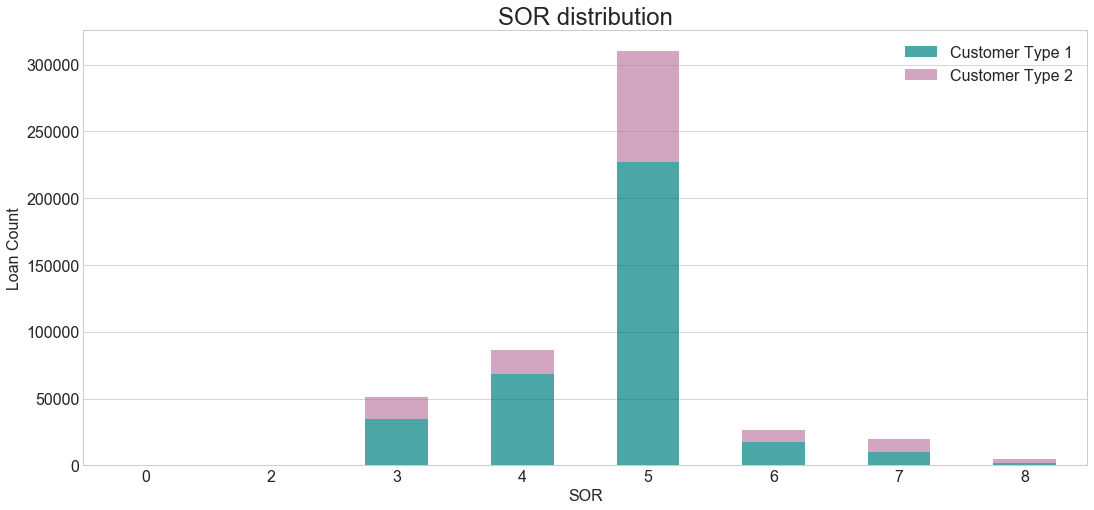

In [4]:
tmp=df.groupby(['SOR','CustomerType'])['Customer_WID'].count().reset_index(name="LoanCount")
tmp=tmp.pivot(index="SOR",columns = "CustomerType", values="LoanCount")
tmp.columns = ["Customer Type 1", "Customer Type 2"]
tmp["SOR"] = tmp.index
tmp.SOR = tmp.SOR.astype(np.int)
tmp = tmp.fillna(0)
stacked_barplot(data=tmp, x='SOR', y=['Customer Type 1', 'Customer Type 2'], \
        title='SOR distribution', xlabel='SOR', ylabel='Loan Count')

The majority of customers are in **'SOR'** 5.  
Distribution of customer type 1 and customer type 2 are stable.

In original dataset column **'DisbursementDate'** has type 'object', but contains date values so I made a type conversion to datetime in **'df'** dateset.  
Loan Disbursement Dates in dataset starts at **{{DateContainer.min_month}} {{DateContainer.year}}** ends at **{{DateContainer.max_month}} {{DateContainer.year}}**, a period is equal to **{{DateContainer.month_day_count.months}}** months and **{{DateContainer.month_day_count.days}}** days

In [ ]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Customer_WID']. \
        count().reset_index(name="LoanCount").sort_values('DisbursementDate')
loan_count_per_month_mean=tmp.LoanCount.mean()
loan_count_per_month_max=tmp.LoanCount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]
title='Count of loans per month'
barplot(tmp, 'DisbursementDate','LoanCount', title, 'Loan Count', 'Months')

In [ ]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Amount']. \
        sum().reset_index(name="LoanAmount").sort_values('DisbursementDate')
loan_amount_per_month_mean=tmp.LoanAmount.mean()
loan_amount_per_month_max=tmp.LoanAmount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]  
barplot(tmp, 'DisbursementDate','LoanAmount', 'Loan amount per month', 'Months', 'Loan Amount')

Mainly loan disbursement trend is stable with **{{format_number(round(loan_count_per_month_mean))}}** loans for a total value of **{{format_number(round(loan_amount_per_month_mean))}}** on average per month.   
But there appears to be a spike in March when **{{format_number(round(loan_count_per_month_max))}}** loan was issued for a total value of **{{format_number(round(loan_amount_per_month_max))}}**.

**Loan count and amount per day**  
Min loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().min()))}}**  
Max loan count in one day: **{{format_number(round(df.groupby(df_original.DisbursementDate).Customer_WID.count().max()))}}**  
Avarege loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().mean()))}}**  

Min loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().min()))}}**  
Max loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().max()))}}**  
Avarege loan amount in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Amount.sum().mean()))}}**  

In [ ]:
tmp = df.groupby('Customer_WID')["Customer_WID"].count().reset_index(name="LoanCount").\
groupby("LoanCount").count().reset_index().rename(columns={"Customer_WID": "CustomerCount"})
pct_repeat_customers=(tmp[tmp.LoanCount>1].CustomerCount.sum()/tmp.CustomerCount.sum())*100
title='Number of costomers by loan count (%s - %s %s)' %(DateContainer.min_month_abbr,
        DateContainer.max_month_abbr, DateContainer.year)
barplot(tmp, 'LoanCount', 'CustomerCount', title, 'Loan Count', 'Customer Count')

The chart above shows that **{{round(pct_repeat_customers,2)}}%** of customers have taken more than 1 loan in less than one year period

In [ ]:
lineplot(df_original.groupby('Age')['Customer_WID'].count(),
         'Loan count by age',
         'Customer Age',
         'Loan Count'
         )

In [ ]:
age_less18_pct=round(df_original[df_original.Age<18]['Customer_WID'].count()\
                 /df_original['Customer_WID'].count()*100,3)
age_more80_pct=round(df_original[(df_original.Age>80)&(df_original.Age<117)]['Customer_WID']\
                .count()/df_original['Customer_WID'].count()*100,3)
age_117_pct=round(df_original[df_original.Age==117]['Customer_WID'].count() \
              /df_original['Customer_WID'].count()*100,3)
age_118_count=df_original[df_original.Age==118]['Customer_WID'].count()
age_18_80=df_original[(df_original.Age>=18)&(df_original.Age<=80)]

The youngest customer is **{{int(df_original.Age.min())}}** years old  
The eldest customer is **{{int(df_original.Age.max())}}** years old  

The avarege customer age is **{{round(df_original.Age.mean())}}**.  
Age median is **{{round(df_original.Age.median())}}**.  
Age mode is **{{int(df_original.Age.mode())}}**, it means that the most customers take loans at 30 years.  
Age standard deviation is **{{round(df_original.Age.std(),3)}}**

**{{age_less18_pct}}%** customers are younger than 18 years,  in my analysis, I will suppose that loan can only be given to a person who is at least 18 years old.  
 
**{{age_more80_pct}}%** customers are between 80 years and 117 years, also {{age_118_count}} customers are 118 years old. I am not sure that this data is valid and the row count is small so I will not take thid data, when I do age binning.   

**{{age_117_pct}}%** is 117 years old. If a person born in 1900 and a loan was taken in 2017, customer can be 117 years old, but probably that is the earliest year that can be chosen and it has been put as default.  

I have removed rows where customer age is less than 18 and more than 80 in **'df'** dataset, because those rows are not trustable. Age standard deviation will be changed from **{{round(df_original.Age.std(),3)}}** to **{{round(age_18_80.Age.std(),3)}}**

In [ ]:
lineplot(df_original,
         'Average loan amount over age with confidence interval',
         'Customer Age',
         'Loan Amount',
         x='Age',
         y='Amount',
         )

The line plot with error bands showing a confidence interval. For customer between 20 and 80 years errors a much smaller, than for customer who younger than 20 or elder than 80.

In [ ]:
tmp = df_original.groupby("CustomerType").count().reset_index()
pct_loans_customer_1=(tmp[tmp.CustomerType==1.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
pct_loans_customer_2=(tmp[tmp.CustomerType==2.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
barplot(tmp, 'CustomerType', 'Customer_WID', 'Loan count by customer type', \
        'Customer Type', 'Loans', figsize=(18,6))

Internal customer type classification contains two types: '1', '2', but dataset also have 2 customers with type '3' and one customer with type '0'.  
I have deleted those 3 rows from **'df'** dataset.  
The plot above shows that **{{round(pct_loans_customer_1,2)}}%** of the loans are issued to customer type **'1'** ** and **{{round(pct_loans_customer_2,2)}}%** to customer type **'2'**.  
This leads me to believe that customer type **'1'** is a retail customer, while customer type **'2'** could be business or SME (small and medium enterprises) customer.

In [ ]:
amount_min_customer_1=df[df.CustomerType==1.0].Amount.min()
amount_max_customer_1=df[df.CustomerType==1.0].Amount.max()
amount_median_customer_1=df[df.CustomerType==1.0].Amount.median()
amount_min_customer_2=df[df.CustomerType==2.0].Amount.min()
amount_max_customer_2=df[df.CustomerType==2.0].Amount.max()
amount_median_customer_2=df[df.CustomerType==2.0].Amount.median()
densityplot(df_original[df_original.CustomerType.isin([1, 2])], "Amount", 'CustomerType', 
        'Loan amount distribution by customer type', 
        'Loan amount', 'Density')

In [ ]:
boxplot(df, 'CustomerType', 'Amount', 'Amount of loan per Customer Type', \
        'Customer Type', 'Amount', yscale="log")

Medium amount for customer **'1'** is **{{format_number(amount_median_customer_1)}}** that is lower than median for costomer **'2'** with median **{{format_number(amount_median_customer_2)}}**.  
Customer type **'2'** distrubution is wider than customer type **'1'** distribution.  
The minimum amount is **{{format_number(amount_min_customer_2)}}**, the maximum amount is **{{format_number(int(amount_max_customer_1))}}** for customer **'1'** and **'2'**

## Default predictors

Lets start predictor exploration with **Credit Rating Bureau score** 

In [ ]:
lineplot(df, 
         'Probability of default by CBR Score', 
         'CBR Score Groups', 
         'Probability of default', 
          x='CRBScoreBin', 
          y='Default', xticks=10,percent=True
          )

In general **Credit Rating Bureau score** is predictive and the higher the score, the lower the probability of default is. But also score has bad discriminative power between **542** and **588**, where the probability of default is not monotone.

In [ ]:
lineplot(df, 
         'Probability of default by age group', 
         'Customer Age Groups', 
         'Probability of default', 
          x='AgeBin', 
          y='Default', xticks=12,percent=True
          )

Across these **age groups** probability of default varies between approximately from **1%** to **5%**.  
In general probability of default is lower in older age groups.

## Predictor interactions

## 3.3. Customer Type

## 3.N. Default

In [ ]:
mapping={
    0 : 'Loan paid',
    1 : 'Loan defaulted'
    }
tmp=[df_original]
for d in tmp:
    d['DefaultLabel']=d.Default.map(mapping)

# 4. Feature engineering 
Describe and show code that transforms your original dataset into dataset ready for prediction.

### <font color=red>Since you have customer identifier and date, when loan was issued you can try to build additional features based on previous loans.</font>

## 4.1. Remove NaN values

## 4.2. Quantize age

# 5. Feature selection 
Describe how you approached feature selection: which features you decided to include in your models and why.

# 6. Modeling 
Describe different binary classification models you used for this project. Ensure that you are correctly splitting dataset into train and test.
Model evaluation - describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

<font color=red>
For credit scoring it is crucially important to start of with model, that is explainable and robust to outliers. Then you might want to investigate more complicated models, and provide a tradeof between explainability and predictive power.   

At the end you need to provide estimated monthly revenue by using your credit scoring model (refer to business variables above) and what is the cutoff for loan acceptance.</font>

# 7. Model evaluation 
Describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

# 8. Recommendation 
A small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

# 9. Conclusion 
Final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.